In [44]:
import yfinance as yf
import matplotlib.pyplot as plt

In [45]:
sp500 = yf.Ticker("^GSPC")

In [46]:
sp500 = sp500.history(period="max")
#sp500

In [47]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2025-06-26 00:00:00-04:00', '2025-06-27 00:00:00-04:00',
               '2025-06-30 00:00:00-04:00', '2025-07-01 00:00:00-04:00',
               '2025-07-02 00:00:00-04:00', '2025-07-03 00:00:00-04:00',
               '2025-07-07 00:00:00-04:00', '2025-07-08 00:00:00-04:00',
               '2025-07-09 00:00:00-04:00', '2025-07-10 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24496, freq=None)

<Axes: xlabel='Date'>

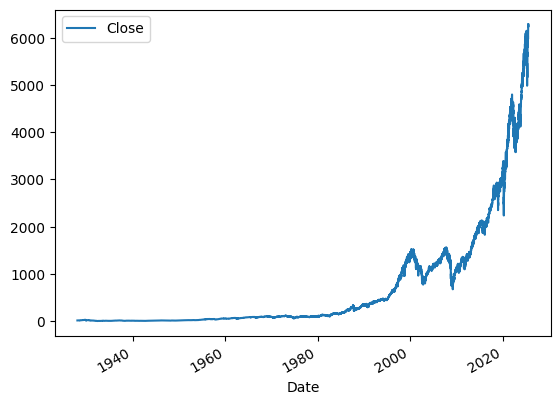

In [48]:
sp500.plot.line(y="Close", use_index=True)

In [49]:
# Cleaning data
del sp500["Dividends"]
del sp500["Stock Splits"]

In [50]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)
#sp500

In [51]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
#sp500

In [52]:
sp500 = sp500.loc["1990-01-01":].copy()
#sp500

In [53]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,100
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [54]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [55]:
import pandas as pd
preds = pd.Series(preds, index=test.index)

In [56]:
precision_score(test["Target"], preds)

0.5609756097560976